In [1]:
import matplotlib.pyplot as plt
import numpy as np

In [155]:
suffix = "all_100"
base_dir = f"/home/ccl/svox2/opt/ckpt_auto/128_to_256_scannerf_{suffix}/airplane1/test_renders"
c2ws = np.load(f"{base_dir}/c2ws.npy")


c2ws = np.load(f"{base_dir}/c2ws.npy")
c2ws_train = np.load(f"{base_dir}/c2ws_train.npy")

center_pt = np.mean(c2ws[:,:3,3], axis=0)
directions_train = (c2ws_train[:,:3,3] - center_pt)
directions = (c2ws[:,:3,3] - center_pt)
directions_train = directions_train / np.linalg.norm(directions_train, keepdims=True, axis=1)
directions = directions / np.linalg.norm(directions, keepdims=True, axis=1)
cos_dist = np.matmul(directions, directions_train.transpose())
closest_train_index = np.argmax(cos_dist, axis=1)
cos_dist = np.max(cos_dist, axis=1)
angles = np.arccos(cos_dist)
abs_angles = np.arctan2(directions[:,0], directions[:,2])

def get_metrics(base_dir):
    psnr = np.load(f"{base_dir}/psnr.npy")
    psnr_train = np.load(f"{base_dir}/psnr.npy")
    return psnr, psnr_train
    
# suffixes = ["all_100", "all_250", "all_500", "all"]
suffixes = ["all_100","all"]
psnrs = []
psnrs_train = []

for suffix in suffixes:
    base_dir2 = f"/home/ccl/svox2/opt/ckpt_auto/128_to_256_scannerf_{suffix}/airplane1/test_renders"

    psnr, psnr_train = get_metrics(base_dir2)
    psnrs.append(psnr)
    psnrs_train.append(psnr_train)
    # psnr_train = np.load(f"{base_dir}/psnr_train.npy")
    # psnr_diff = psnr_train[closest_train_index] - psnr

psnrs = np.stack(psnrs)
psnrs_train = np.stack(psnrs_train)
best_psnr = np.max(psnrs, axis=0)
best_psnr_idx = np.argmax(psnrs, axis=0)

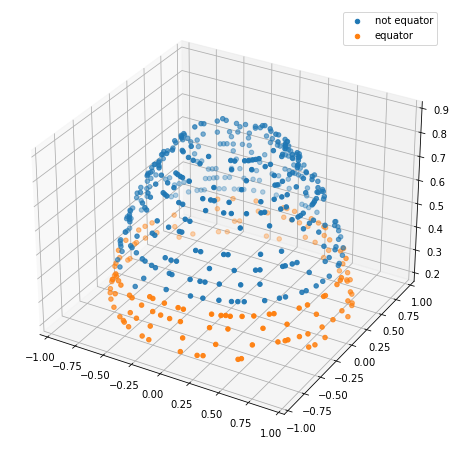

In [165]:
fig = plt.figure(figsize=(10,8))
# ax = fig.add_subplot()
ax = fig.add_subplot(projection='3d')
equator_threshold = -0.4
equator = np.where(c2ws[:,1,3] > equator_threshold)
not_equator = np.where(c2ws[:,1,3] < equator_threshold)
ax.scatter(c2ws[not_equator,0,3],c2ws[not_equator,2,3],-c2ws[not_equator,1,3], label="not equator")
ax.scatter(c2ws[equator,0,3],c2ws[equator,2,3],-c2ws[equator,1,3], label="equator")
ax.legend()
fig.savefig("/home/ccl/Downloads/plots/EQUATOR_FILTER.jpeg")

psnr_filtered = psnrs[:,equator]
c2ws_filtered = c2ws[equator]
abs_angles_filtered = abs_angles[equator]
angles_filtered = angles[equator]

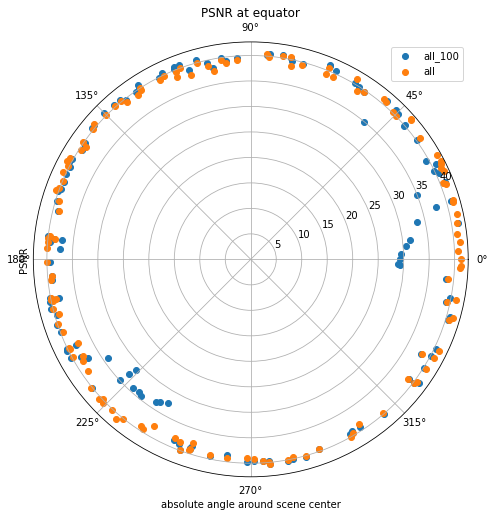

In [164]:
fig = plt.figure(figsize=(10,8))
# ax = fig.add_subplot()
ax = fig.add_subplot(projection='polar')
plt.ylabel("PSNR")
plt.xlabel("absolute angle around scene center")
plt.title("PSNR at equator")
x = abs_angles_filtered
for i, suffix in enumerate(suffixes):
    y = psnr_filtered[i]
    idx = np.argsort(x)
    # ax.plot(x[idx], y[0,idx], label=f"{suffix}")
    # print(x[idx])
    # print(y[0,idx])
    ax.scatter(x, y[0], label=f"{suffix}")

ax.legend()
fig.savefig("/home/ccl/Downloads/plots/PSNR_EQUATOR.jpeg")

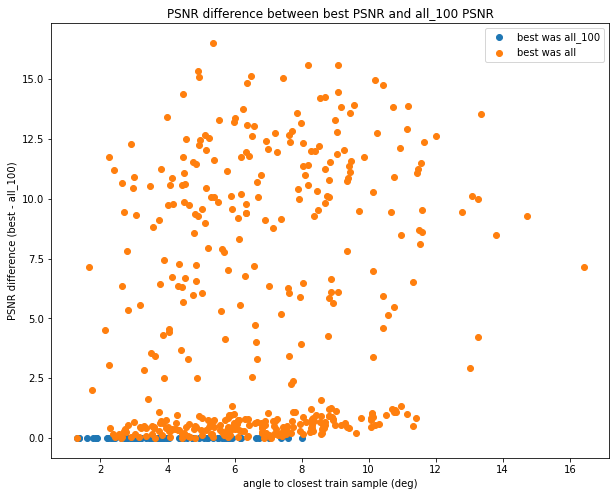

In [160]:
fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot()
# ax = fig.add_subplot(projection='polar')
plt.ylabel("PSNR difference (best - all_100)")
plt.xlabel("angle to closest train sample (deg)")
plt.title("PSNR difference between best PSNR and all_100 PSNR")
x = angles*180/np.pi
y = best_psnr - psnrs[0]
for i, suffix in enumerate(suffixes):
    current_suffix = np.where(best_psnr_idx == i)
    ax.scatter(x[current_suffix],y[current_suffix], label=f"best was {suffix}")

ax.legend()
fig.savefig("/home/ccl/Downloads/plots/PSNR_DIFF_REL.png")

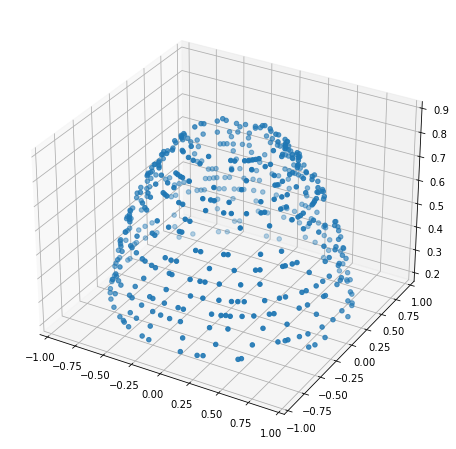